In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, './simile')

import importlib
import simile as sml
importlib.reload(sml)

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from rdkit.Chem import MolFromSmiles, rdFMCS, MolToInchiKey

/var/folders/yd/wk0sjvrj5q379l6mjply6h4c0000gn/T/ipykernel_7089/1739690547.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Option 1: Load Example Data

In [2]:
mzi = []
pmz = []
mols = []
spec_name = None
tolerance = .01

for ex in ['1','5a','5b','5c']:
    df = pd.read_json('./example_data/fig{}.json'.format(ex))
    mzi.append(np.array((df.iloc[0].spectrum)))
    mzi.append(np.array((df.iloc[1].spectrum)))

    pmz.append(df.iloc[0].precursor_mz)
    pmz.append(df.iloc[1].precursor_mz)

    mols.append(MolFromSmiles(df.iloc[0].smiles))
    mols.append(MolFromSmiles(df.iloc[1].smiles))


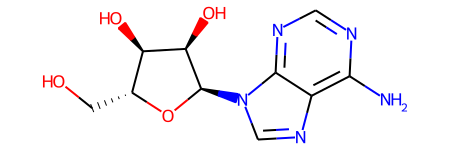

In [3]:
mols[6]

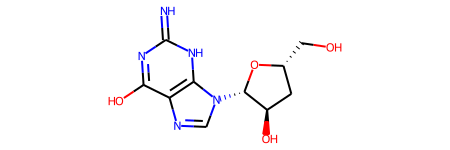

In [4]:
mols[7]

In [5]:
res = rdFMCS.FindMCS([mols[-1],mols[-2]],timeout=10,ringMatchesRingOnly=False)
A = mols[-1].GetNumBonds()
B = mols[-2].GetNumBonds()
AB = res.numBonds 
jaccard_similarity = AB / (A+B-AB)
jaccard_similarity

0.8260869565217391

## Option 2: Generate Synthetic Data

In [16]:
mzi = []
pmz = []
mols = []
spec_name = []
tolerance = .01

a = 20 + np.random.random_sample()/10
b = 8  + np.random.random_sample()/10
c = 5  + np.random.random_sample()/10
d = 1  + np.random.random_sample()/10

mzi.append(np.array([[c,b,a,a+c,a+b,a+b+c]
                for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('none')

mzi.append(np.array([[c,b+d,a,a+c,a+b+d,a+b+c+d]
                for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('b')


mzi.append(np.array([[c,c+d,b,b+d,a,a+c+d,a+b+d,a+b+c+d,a+b+c+2*d]
                 for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('b+c')


mzi.append(np.array([[c+d,b,a,a+c+d,a+b,a+b+c+d]
                 for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('c')


## Option 3: Load GNPS Data

In [10]:
mzi = []
pmz = []
mols = []
spec_name = None
tolerance = .33


import requests
url1 = 'https://metabolomics-usi.ucsd.edu/json/?usi1=mzspec:GNPS:TASK-e3642744dc754c73ab780797577c62d2-spectra/specs_ms.mgf:scan:2021'
url2 = 'https://metabolomics-usi.ucsd.edu/json/?usi1=mzspec:GNPS:TASK-e3642744dc754c73ab780797577c62d2-spectra/specs_ms.mgf:scan:2025'

r = requests.get(url1)
mzi.append(np.asarray(r.json()['peaks']).T)
pmz.append(r.json()['precursor_mz'])

r = requests.get(url2)
mzi.append(np.asarray(r.json()['peaks']).T)
pmz.append(r.json()['precursor_mz'])


## SIMILE Substitution Matrix, Alignment Score, and Alignment P-value

### Select Spectra

In [17]:
## Subsample spectra of interest by slicing 
mzs = np.array([mz for (mz,i) in mzi])#[[6,7]]
pmzs = np.array(pmz)#[[6,7]]

/var/folders/yd/wk0sjvrj5q379l6mjply6h4c0000gn/T/ipykernel_7089/1043479681.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mzs = np.array([mz for (mz,i) in mzi])#[[6,7]]


### Run SIMILE

Scores: (1.7020384140193114, 1.0), P-value: 0.0018902594358390886, Matches: (27, 0)
CPU times: user 579 ms, sys: 386 ms, total: 965 ms
Wall time: 202 ms


<timed exec>:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


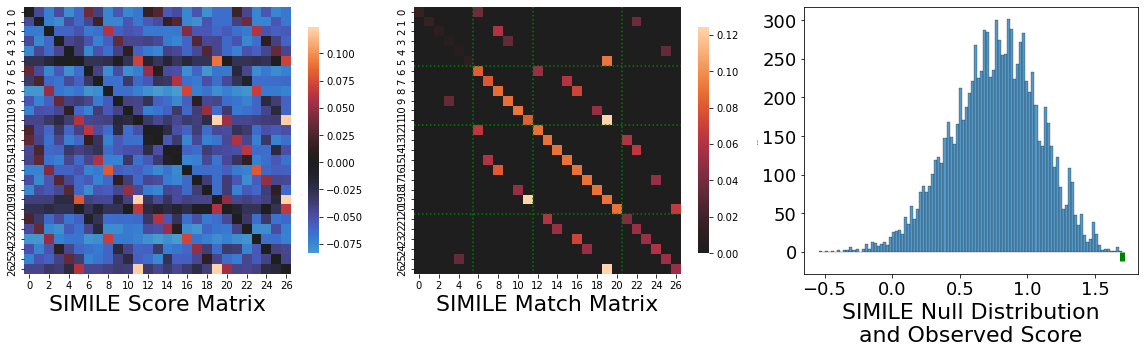

In [18]:
%%time
# %matplotlib inline
sml = importlib.reload(sml)

# SIMILE ##############################################################################################################
S, spec_ids = sml.similarity_matrix(mzs, pmzs=pmzs, tolerance=.33)

C = sml.inter_intra_compare(spec_ids)

# Set comparisons so only consecutive spectra are "good"
# C = 2*np.maximum(np.equal.outer(spec_ids,spec_ids+1),
#                  np.equal.outer(spec_ids,spec_ids-1))-1

# Each fragment ion can only match once
# M = sml.pairwise_match(S)

# Each fragment ion can only match once per fragmentation spectra
M = sml.multiple_match(S,spec_ids)

score, scores, probs = sml.match_scores(S,C,M, spec_ids, gap_penalty=4)
pro = scores.clip(0).sum()
con = -scores.clip(None,0).sum()

pval,null_dist = sml.z_test(scores, probs, return_dist=True, log_size=4)

# Plotting ###########################################################################################################
print('Scores: {}, P-value: {}, Matches: {}'.format((pro,score),pval, (((M*C)>0).sum(),-((M*C)<0).sum())))
fig,ax= plt.subplots(1,3,figsize=(16,16))

sns.heatmap(S, 
            cbar_kws={"shrink": .2},
            center=0,linewidths=0.0, rasterized=True, ax=ax[0])
ax[0].xaxis.set_label_text('SIMILE Score Matrix', fontsize=22)
# ax[0].vlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
# ax[0].hlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')


sns.heatmap(S*C*M+np.diag(scores), 
            cbar_kws={"shrink": .2},
            center=0,linewidths=0.0, rasterized=True, ax=ax[1])
ax[1].xaxis.set_label_text('SIMILE Match Matrix', fontsize=22)
ax[1].vlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[1].hlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[1].set_aspect(1.0/ax[2].get_data_ratio(), adjustable='box')


sns.histplot(null_dist.real, ax=ax[2], stat='count',bins=100)
ax[2].xaxis.set_label_text('SIMILE Null Distribution\nand Observed Score', fontsize=22)
ax[2].yaxis.set_label_text('Count', fontsize=2)
ax[2].xaxis.set_tick_params(labelsize=18)
ax[2].yaxis.set_tick_params(labelsize=18)
ax[2].vlines((pro-con),0,-ax[2].get_ylim()[1]/25,color='g',linewidth=5)
ax[2].set_aspect(.8/ax[2].get_data_ratio(), adjustable='box')

fig.tight_layout()
fig.show()

In [19]:
sml.matching_ions_report(S,C,M,mzs,pmzs).query('type=="pro"').sort_values('score',ascending=False).head(50)

,spec_key_1,spec_key_2,pmz_1,pmz_2,mz_1,mz_2,mz_diff,nl_diff,score,type
15,2,3,35.348531,34.260122,34.260122,34.260122,0.000000,NaN,0.124207,pro
10,1,2,34.260122,35.348531,34.260122,34.260122,0.000000,NaN,0.124207,pro
5,0,2,33.171714,35.348531,33.171714,34.260122,-1.088408,NaN,0.090771,pro
13,2,3,35.348531,34.260122,20.095610,20.095610,0.000000,1.088408,0.080750,pro
8,1,2,34.260122,35.348531,20.095610,20.095610,0.000000,-1.088408,0.071638,pro
16,2,3,35.348531,34.260122,35.348531,34.260122,1.088408,NaN,0.065734,pro
12,2,3,35.348531,34.260122,8.050906,8.050906,0.000000,1.088408,0.064114,pro
7,1,2,34.260122,35.348531,9.139314,9.139314,0.000000,-1.088408,0.060868,pro
2,0,1,33.171714,34.260122,20.095610,20.095610,0.000000,-1.088408,0.060118,pro
11,2,3,35.348531,34.260122,6.113606,6.113606,0.000000,1.088408,0.059408,pro
